# Topic modeling for tags

1. Content aggregation: By scraping news headlines and tags from multiple sources, it is possible to create a news aggregation platform that provides a comprehensive overview of the latest stories on a variety of topics.

2. Sentiment analysis: By analyzing the sentiment of news headlines over time, it is possible to track changes in public opinion on various topics. This could be useful for businesses, governments, and other organizations that want to understand how their actions or policies are being received by the public.

3. Market research: By tracking the frequency and content of news articles related to specific industries or companies, it is possible to gain insights into market trends and the performance of individual firms.

4. Media monitoring: By tracking the publication of news articles related to a specific person, company, or topic, it is possible to monitor media coverage and respond to any negative or false information that may be published.

5. Data visualization: By visualizing the volume and content of news articles over time, it is possible to create graphical representations of trends and patterns in the news. This could be useful for journalists, researchers, or anyone interested in understanding how a particular topic has evolved over time.

How does a topic evolve over time?

In [1]:
import pandas as pd
from collections import Counter
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
sns.set_theme(style="ticks")
sns.set_palette("Paired")


In [2]:
def flatten(l):
    return [item for sublist in l for item in sublist]

In [3]:
# load cleaned dataset
df_news = pd.read_parquet("data/news/tagesschau/2022/tagesschau-news.parquet")
df_news['tags'] = df_news['tags'].apply(lambda x: x.split(','))

# What are the top tags?
df_top_n_tags_for_2022 = pd.read_parquet("data/news/tagesschau/2022/tagesschau-top-tags.parquet")

In [4]:
df_top_n_tags_for_2022

,tag,count
0,Ukraine,2644
1,Russland,1527
2,Coronavirus,1103
3,USA,663
4,Energiekrise,525
5,EU,472
6,Ukraine-Krieg,437
7,China,425
8,Liveblog,405
9,Inflation,404


In [5]:
# What tags are occurring together?

df_source_target_mapping = pd.DataFrame()
# Give me all articles where I can find the tag

for tag in df_top_n_tags_for_2022['tag']:
    relevant_tags = []
    for tags in df_news['tags'].values:
        if tag in tags:
            relevant_tags.append(tags)
            
    absolute_counts = pd.Series(flatten(relevant_tags)).value_counts()
    relative_counts = pd.Series(flatten(relevant_tags)).value_counts(normalize=True)
    df_relevant_tags_counts = pd.DataFrame({'target': absolute_counts.index, 'count': absolute_counts.values, 'rel_count': relative_counts.values})
    df_relevant_tags_counts.drop(index=df_relevant_tags_counts.query("target == @tag").index, inplace=True)
    df_relevant_tags_counts['source'] = tag
    df_source_target_mapping = pd.concat([df_source_target_mapping, df_relevant_tags_counts], axis=0)

In [6]:
df_source_target_mapping

,target,count,rel_count,source
1,Russland,967,0.104541,Ukraine
2,Liveblog,304,0.032865,Ukraine
3,Krieg,267,0.028865,Ukraine
4,Ukraine-Krieg,228,0.024649,Ukraine
5,Mariupol,121,0.013081,Ukraine
...,...,...,...,...
219,Indexfonds,1,0.000556,Börse
220,ETF,1,0.000556,Börse
221,Importstopp,1,0.000556,Börse
222,Aktie,1,0.000556,Börse


In [7]:
df_source_target_mapping.query("rel_count > 0.01")

,target,count,rel_count,source
1,Russland,967,0.104541,Ukraine
2,Liveblog,304,0.032865,Ukraine
3,Krieg,267,0.028865,Ukraine
4,Ukraine-Krieg,228,0.024649,Ukraine
5,Mariupol,121,0.013081,Ukraine
...,...,...,...,...
10,Aktien,24,0.013356,Börse
11,Kurssturz,22,0.012243,Börse
12,Tesla,21,0.011686,Börse
13,Geldanlage,21,0.011686,Börse


<AxesSubplot:xlabel='count', ylabel='target'>

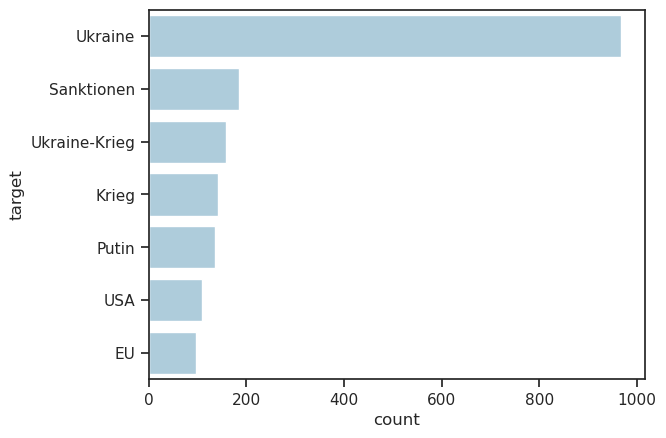

In [8]:
fig, ax = plt.subplots()
sns.barplot(data=df_source_target_mapping.query("(rel_count > 0.01) & (source == 'Russland')"), y='target', x='count', color='C0')

## Topic modeling

In [9]:
topics = df_source_target_mapping['source'].unique().tolist()
print(topics)

['Ukraine', 'Russland', 'Coronavirus', 'USA', 'Energiekrise', 'EU', 'Ukraine-Krieg', 'China', 'Liveblog', 'Inflation', 'Investigativ', 'Krieg', 'DAX', 'Scholz', 'Börse']


There are several ways to create all pairs from a list in Python, depending on the desired output format and level of complexity. Here we are using the module itertools

In [10]:

tag_pairs = list(itertools.combinations(topics, 2))
print(tag_pairs)


[('Ukraine', 'Russland'), ('Ukraine', 'Coronavirus'), ('Ukraine', 'USA'), ('Ukraine', 'Energiekrise'), ('Ukraine', 'EU'), ('Ukraine', 'Ukraine-Krieg'), ('Ukraine', 'China'), ('Ukraine', 'Liveblog'), ('Ukraine', 'Inflation'), ('Ukraine', 'Investigativ'), ('Ukraine', 'Krieg'), ('Ukraine', 'DAX'), ('Ukraine', 'Scholz'), ('Ukraine', 'Börse'), ('Russland', 'Coronavirus'), ('Russland', 'USA'), ('Russland', 'Energiekrise'), ('Russland', 'EU'), ('Russland', 'Ukraine-Krieg'), ('Russland', 'China'), ('Russland', 'Liveblog'), ('Russland', 'Inflation'), ('Russland', 'Investigativ'), ('Russland', 'Krieg'), ('Russland', 'DAX'), ('Russland', 'Scholz'), ('Russland', 'Börse'), ('Coronavirus', 'USA'), ('Coronavirus', 'Energiekrise'), ('Coronavirus', 'EU'), ('Coronavirus', 'Ukraine-Krieg'), ('Coronavirus', 'China'), ('Coronavirus', 'Liveblog'), ('Coronavirus', 'Inflation'), ('Coronavirus', 'Investigativ'), ('Coronavirus', 'Krieg'), ('Coronavirus', 'DAX'), ('Coronavirus', 'Scholz'), ('Coronavirus', 'Börse

In [11]:
multi_index = pd.MultiIndex.from_tuples(tag_pairs)
df_tag_mapping = pd.DataFrame(data={'tags': None, 'score': None}, index=multi_index)

for tag_pair in tag_pairs:
    tag_series = [df_source_target_mapping.query("(rel_count > 0.005) & (source == @tag)")['target'] for tag in tag_pair]
    mask = tag_series[0].isin(tag_series[1])
    intersection = {
        'tags': tag_series[0][mask].to_list(),
        'score': mask.sum() / len(mask)
    }
    for key in intersection.keys():
        df_tag_mapping.loc[tag_pair, key] = intersection[key]



In [12]:
df_tag_mapping.query("score > 0.5")

tags  \
Ukraine  Russland       [Krieg, Ukraine-Krieg, Mariupol, Putin, EU, Se...   
         Ukraine-Krieg  [Russland, Liveblog, Putin, EU, Selenskyj, Sch...   
Liveblog Investigativ     [Ukraine, Coronavirus, Ukraine-Krieg, Russland]   
         Scholz                        [Ukraine, Ukraine-Krieg, Russland]   
DAX      Börse          [Dow Jones, Marktbericht, Fed, Gold, Inflation...   

                           score  
Ukraine  Russland          0.625  
         Ukraine-Krieg     0.625  
Liveblog Investigativ        1.0  
         Scholz             0.75  
DAX      Börse          0.909091

In [13]:
aggregated_topics = pd.DataFrame(df_tag_mapping.query("score > 0.5").index.tolist(), columns=['tag_1', 'tag_2'])\
    .groupby('tag_1')\
    .agg(lambda x: ','.join(x)).reset_index()\
    .apply(lambda x: ','.join(x), axis=1)\
    .tolist()

In [14]:
print("Topics: ", topics)
print("Aggregated topics: ", aggregated_topics)

Topics:  ['Ukraine', 'Russland', 'Coronavirus', 'USA', 'Energiekrise', 'EU', 'Ukraine-Krieg', 'China', 'Liveblog', 'Inflation', 'Investigativ', 'Krieg', 'DAX', 'Scholz', 'Börse']
Aggregated topics:  ['DAX,Börse', 'Liveblog,Investigativ,Scholz', 'Ukraine,Russland,Ukraine-Krieg']


In [15]:
topics_to_remove = ','.join(aggregated_topics).split(',')
new_topics = list(set(topics).difference(set(topics_to_remove)).union(aggregated_topics))
print("New topics: ", new_topics)

New topics:  ['Coronavirus', 'Liveblog,Investigativ,Scholz', 'Krieg', 'USA', 'China', 'Inflation', 'DAX,Börse', 'Energiekrise', 'EU', 'Ukraine,Russland,Ukraine-Krieg']


In [16]:
df_topics = pd.DataFrame(columns=['topic','tag','count'])
for topic in new_topics:
    df_tmp = pd.DataFrame()
    df_tmp[['tag', 'count']] = df_source_target_mapping.query("source in @topic.split(',')")[['target', 'count']].values
    df_tmp['topic'] = topic
    df_topics = pd.concat([df_topics, df_tmp])
    
df_topics = df_topics.groupby(['topic', 'tag']).agg({'count': 'sum'}).reset_index()
df_topics['rel_count'] = df_topics.groupby('topic')['count'].transform(lambda x: x / x.sum())
df_topics['rank'] = df_topics.groupby('topic')['count'].rank(method='average', ascending=False)
df_topics = df_topics.sort_values(['topic','rank'], ascending=[True, True]).set_index(['topic', 'rank'])
# test
# df_tmp.groupby('topic').agg({'rel_count': 'sum'})

In [17]:
df_topics

tag count rel_count
topic                          rank                               
China                          1.0     Coronavirus    86  0.071786
                               2.0        Russland    43  0.035893
                               3.0          Taiwan    37  0.030885
                               4.0             USA    27  0.022538
                               6.0        Lockdown    24  0.020033
...                                            ...   ...       ...
Ukraine,Russland,Ukraine-Krieg 1308.5        Ärzte     1  0.000079
                               1308.5   Ölkonzerne     1  0.000079
                               1308.5    Übernahme     1  0.000079
                               1308.5       Новини     1  0.000079
                               1308.5      Новости     1  0.000079

[6283 rows x 3 columns]

# Evolution of tags
Create a slope graph to show the evolution of tag occurrence between the current and previous month.

In [18]:
import pickle

In [19]:
with open('data/news/tagesschau/2022/summed_tags.pkl', 'rb') as handle:
    summed_tags = pickle.load(handle)


In [20]:
summed_tags['monthly'][summed_tags['monthly'].index.month == 1]


,allTagsPerMonth,tags_frequency
timestamp,,
2022-01-31,"[Silvester, 2021, Neujahr, G7, Russland, China...","{'Silvester': 5, '2021': 6, 'Neujahr': 3, 'G7'..."


In [21]:
mask = summed_tags['monthly'].index.month == 5
tag_counts_5 = summed_tags['monthly'].loc[mask, 'tags_frequency'].item()

mask = summed_tags['monthly'].index.month == 6
tag_counts_6 = summed_tags['monthly'].loc[mask, 'tags_frequency'].item()

mask = summed_tags['monthly'].index.month == 7
tag_counts_7 = summed_tags['monthly'].loc[mask, 'tags_frequency'].item()

mask = summed_tags['monthly'].index.month == 8
tag_counts_8 = summed_tags['monthly'].loc[mask, 'tags_frequency'].item()

In [22]:
df = pd.DataFrame(tag_counts_8.most_common(4), columns=['tag', 'counts_8']).set_index('tag')

In [23]:
df['counts_5'] = 0
df['counts_6'] = 0
df['counts_7'] = 0

for tag in df.index:
    df.loc[tag, 'counts_5'] = tag_counts_5[tag]
    df.loc[tag, 'counts_6'] = tag_counts_6[tag]
    df.loc[tag, 'counts_7'] = tag_counts_7[tag]
    

## Slope graph

In [24]:
import numpy as np
from datetime import date

In [25]:
# # Define the x and y values for the slope
# x = [date(2021,1,1), date(2022,1,1)]
# y = [np.random.randint(1,10, size=len(x)) for _ in range(4)]
# index = x
# labels = [f"Label {i}" for i in range(4)]
# values = y
# df = pd.DataFrame(data={label: value for label, value in zip(labels, values)}, index=index)

In [34]:
def plot_slope_graph(x, y, labels, xticks=None):
    # Create the plot
    if xticks is None:
        xticks = x
    labels_coords = []
    label_counter = {key: 0 for key in [y_[0] for y_ in y]}
    y_offset = 0
    num_digits = len(str(np.max([y_[0] for y_ in y])))
    x_offset = -25 - (5 * num_digits)
    fig, ax = plt.subplots(figsize=(6,8), tight_layout=True)
    for i, y_ in enumerate(y):
        if y_[1] > y_[0]:
            color = 'C0'
            weight = 'bold'
        else:
            color = 'grey'
            weight = 'normal'
        ax.plot(x, y_, color=color, linewidth=3)
        ax.scatter([x[0],x[-1]], [y_[0],y_[-1]], c=color, marker='o', s=100)
        ax.annotate(f"{y_[0]}", xy=(x[0],y_[0]), xytext=(-10,0), textcoords='offset points', horizontalalignment='right', verticalalignment='center', color=color, weight=weight)
        ax.annotate(f"{y_[-1]}", xy=(x[-1],y_[-1]), xytext=(10,0), textcoords='offset points', horizontalalignment='left', verticalalignment='center', color=color, weight=weight)
        
        
        label_coords = (x[0],y_[0])
        label_y_offset = y_offset
        if label_coords in labels_coords:
            label_counter[y_[0]] +=1
            y_offset = 15 * label_counter[y_[0]]
        else:
            y_offset = 0
        ax.annotate(labels[i], xy=label_coords, xytext=(x_offset,0-y_offset), textcoords='offset points', horizontalalignment='right', verticalalignment='center', color=color)
        labels_coords.append((x[0],y_[0]))
        # labels['y_offset'].append(y_offset)
    # if x_label is not None:
    #     ymax = np.max([y_[0] for y_ in y])
    #     ax.annotate(x_label, xy=(x[0],ymax), xytext=(x_offset,30), textcoords='offset points', horizontalalignment='right', verticalalignment='center', color=color)
    #     ax.annotate("|", xy=(x[0],ymax), xytext=(x_offset+5,30), textcoords='offset points', horizontalalignment='center', verticalalignment='center', color=color)
    # if y_label is not None:
    #     ymax = np.max([y_[0] for y_ in y])
    #     ax.annotate(y_label, xy=(x[0],ymax), xytext=(-10,30), textcoords='offset points', horizontalalignment='right', verticalalignment='center', color=color)
    # plt.xticks(x, xticks)
    # remove the y-axis
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # plt.gca().spines['top'].set_visible(False)

    # remove the y-axis
    ax.yaxis.set_visible(False)
    return fig, ax


In [27]:
import calendar

In [28]:
y = df[['counts_5', 'counts_6','counts_7','counts_8']].values
x = [calendar.month_abbr[month_num] for month_num in [5,6,7,8]]
labels = df.index

KeyError: "None of [Index(['counts_5', 'counts_6', 'counts_7', 'counts_8'], dtype='object')] are in the [columns]"

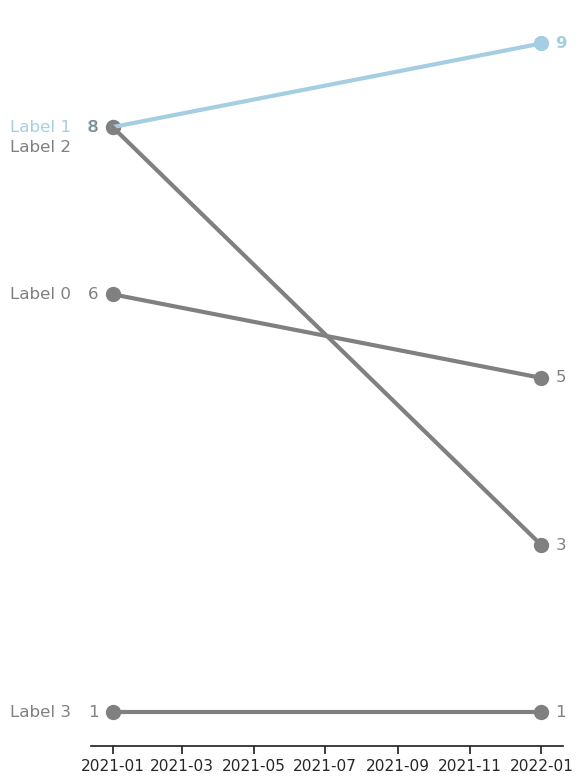

In [35]:
fig, ax = plot_slope_graph(x,y,labels)

In [ ]:
fig.get_figwidth()

6.0

In [ ]:
fig.savefig("data/news/tagesschau/2022/sample-tag-evolution.png", dpi=300, )

# Group tags

In [ ]:
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation


In [ ]:
def custom_analyzer(comma_separated_tags):
    return [x.split(',') for x in comma_separated_tags]

In [ ]:
data_samples = df_news['tags'].apply(lambda x: x.split(',')).tolist()

In [ ]:
# create a dictionary for all tags used and assign integers to each tag
# all tags
all_tags = []
for tags_in_article in data_samples:
    all_tags.extend(tags_in_article)

In [ ]:
# What are the top tags used?

top_tags = df_tags_counts['tag'].values

In [ ]:
unique_tags = sorted(set(top_tags))
vocabulary = {key: value for key, value in zip(unique_tags, range(len(unique_tags)))}

tag_to_index = {key: value for key, value in zip(unique_tags, range(len(unique_tags)))}
index_to_tag = {key: value for key, value in enumerate(unique_tags)}

In [ ]:
# vectorize the article tags with the vocabulary mapping
# example:
# [['Corona', 'Liveblog'], ['Frankreich', 'Corona']] --> [[1, 2], [3, 1]]

test_input = ['Corona', 'Liveblog', 'Test']
test_output = [1, 2]
test_vocabulary = {'Corona': 1, 'Liveblog': 2, 'Frankreich': '3'}

def vectorize_tags(article_tags, vocabulary):
    return [vocabulary[tag] for tag in article_tags if tag in vocabulary]
    

In [ ]:
assert vectorize_tags(test_input, test_vocabulary) == test_output

In [ ]:
vectorized_tags = [vectorize_tags(article_tags, tag_to_index) for article_tags in data_samples]

In [ ]:
vectorized_tags

In [ ]:
test_input = [[1, 2, 4], [2, 3, 1], [5, 4, 1]]
test_vocabulary_id = [0, 1, 2, 3, 4, 5]

In [ ]:
import numpy as np

In [ ]:
# [1, 2, 4] -> [0, 1, 1, 0, 1, 0]
# [2, 3, 1] -> [0, 1, 1, 1, 0, 0]

# 1. get first id in doc
# 2. increment position with 1 in target vector
# 3. get next id in doc and do 2. again

def count_vectorize(doc_ids, vocabulary):
    num_docs = len(doc_ids)
    num_vocabulary_entities = len(vocabulary.values())
    vectors = np.zeros((num_docs, num_vocabulary_entities), dtype=int)
    for doc_count, doc in enumerate((doc_ids)):
        for id in doc:
            vectors[doc_count, id] += 1
    return vectors


In [ ]:
doc_ids_test = [[1, 2], [2, 3], [0], []]
vocabulary_test = {'a':0, 'b':1, 'c':2, 'd':3}

count_vectorize(doc_ids_test, vocabulary_test)

In [ ]:
count_vectorized = count_vectorize(vectorized_tags, tag_to_index)

In [ ]:
# get tfidf results
from sklearn.feature_extraction.text import TfidfTransformer

In [ ]:
tfidf = TfidfTransformer()

In [ ]:
tfidf_vectorized = tfidf.fit_transform(count_vectorized)

In [ ]:
# Reduce dimensionality
from sklearn.decomposition import TruncatedSVD

In [ ]:
tsvd = TruncatedSVD(n_components=10)
tsvd.fit(tfidf_vectorized)

In [ ]:
tsvd.explained_variance_ratio_

In [ ]:
X_tsvd = tsvd.transform(tfidf_vectorized)

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
kmeans = KMeans(n_clusters=5, max_iter=100, n_init=1)

In [ ]:
kmeans.fit(X_tsvd)

In [ ]:
cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)

In [ ]:
cluster_sizes

In [ ]:
[index_to_tag[index] for index in tsvd.inverse_transform(kmeans.cluster_centers_).argsort()[:, ::-1][4]]

In [ ]:
kmeans.cluster_centers_

In [ ]:
lda = LatentDirichletAllocation()
lda.fit(count_vectorized)

In [ ]:
lda.transform(vectorized_tfidf[-2:])

In [ ]:
lda.components_.shape

In [ ]:
topic = lda.components_[0]

In [ ]:
topic

In [ ]:
top_words = topic.argsort()[:-20:-1]

In [ ]:
[index_to_tag[index] for index in top_words]

In [ ]:
from gensim import utils

In [ ]:
utils.simple_preprocess("This is a simple line")

In [ ]:
import gensim.models

In [ ]:
model = gensim.models.Word2Vec(sentences=data_samples, window=2, vector_size=100)

In [ ]:
model.wv['EU']

In [ ]:
all_tags_series.sample(1)

In [ ]:
print(model.wv.wmdistance(["USA"], ["Homeoffice"]))
print(model.wv.wmdistance(["USA"], ["Biden"]))
print(model.wv.wmdistance(["USA"], ["Ukraine"]))
print(model.wv.wmdistance(["Krieg"], ["Ukraine"]))
print(model.wv.wmdistance(["Krieg"], ["Mondmission"]))
print(model.wv.wmdistance(["Russland"], ["Putin"]))
print(model.wv.wmdistance(["Impfung"], ["Putin"]))

In [ ]:
print(model.wv.most_similar(["Landtagswahl"], topn=100))

In [ ]:
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling


def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  # fixed-width numpy strings

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


x_vals, y_vals, labels = reduce_dimensions(model)

def plot_with_plotly(x_vals, y_vals, labels, plot_in_notebook=True):
    from plotly.offline import init_notebook_mode, iplot, plot
    import plotly.graph_objs as go

    trace = go.Scatter(x=x_vals, y=y_vals, mode='text', text=labels)
    data = [trace]

    if plot_in_notebook:
        init_notebook_mode(connected=True)
        iplot(data, filename='word-embedding-plot')
    else:
        plot(data, filename='word-embedding-plot.html')


def plot_with_matplotlib(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    #
    # Label randomly subsampled 25 data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

try:
    get_ipython()
except Exception:
    plot_function = plot_with_matplotlib
else:
    plot_function = plot_with_plotly

plot_function(x_vals, y_vals, labels)